In [51]:
#AlphaVantage API key: ZAPAOIYTE4U33ASM
import requests
import pandas as pd
import numpy as np
from io import StringIO

api_key = "ZAPAOIYTE4U33ASM"
base_url = "https://www.alphavantage.co/query"

base_currencies = ['USD', 'EUR', 'JPY', 'GBP', 'AUD', 'CAD', 'CHF', 'CNH']
target_currencies_test = ['USD', 'EUR'] #Replace with full list for publication

def calculate_returns(group):
    group = group.sort_values(by='timestamp', ascending = True)
    group['returns'] = group['close'].pct_change()
    group['returns'].iloc[0] = np.nan
    return group

dfs = []

for base_currency in base_currencies:
    for target_currency in target_currencies_test:
        if base_currency == target_currency:
            continue
        params = {'function': 'FX_DAILY',
                  'from_symbol': base_currency,
                  'to_symbol': target_currency,
                  'outputsize': 'full',
                  'datatype': 'csv',
                  'apikey': api_key}
        response = requests.get(base_url, params=params)
        df = pd.read_csv(StringIO(response.text), header=None, names=['timestamp', 'open', 'high', 'low', 'close'])
        df = df.drop(0).reset_index(drop=True)
        
        df['from_currency'] = base_currency
        df['to_currency'] = target_currency
        df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)
        
        df = df.groupby(['from_currency', 'to_currency']).apply(calculate_returns)
    
        dfs.append(df)
        
df = pd.concat(dfs)
df = df.reset_index(drop=True)

df.head()

,timestamp,open,high,low,close,from_currency,to_currency,returns
0,2014-11-24,0.8081,0.8085,0.8032,0.8036,USD,EUR,NaN
1,2014-11-25,0.8037,0.8059,0.8007,0.8014,USD,EUR,-0.002738
2,2014-11-26,0.8014,0.8034,0.7980,0.7993,USD,EUR,-0.002620
3,2014-11-27,0.7993,0.8024,0.7983,0.8022,USD,EUR,0.003628
4,2014-11-28,0.8023,0.8044,0.8004,0.8028,USD,EUR,0.000748


In [42]:
#Full target currency list (For efficiency purposes implement last)

target_currencies = [
    'AED', 'AFN', 'ALL', 'AMD', 'ANG', 'AOA', 'ARS', 'AUD', 'AWG', 'AZN',
    'BAM', 'BBD', 'BDT', 'BGN', 'BHD', 'BIF', 'BMD', 'BND', 'BOB', 'BRL',
    'BSD', 'BTN', 'BWP', 'BYN', 'BZD', 'CAD', 'CDF', 'CHF', 'CLP', 'CNY',
    'COP', 'CRC', 'CUP', 'CVE', 'CZK', 'DJF', 'DKK', 'DOP', 'DZD', 'EGP',
    'ERN', 'ETB', 'EUR', 'FJD', 'FKP', 'FOK', 'GBP', 'GEL', 'GGP', 'GHS',
    'GIP', 'GMD', 'GNF', 'GTQ', 'GYD', 'HKD', 'HNL', 'HRK', 'HTG', 'HUF',
    'IDR', 'ILS', 'IMP', 'INR', 'IQD', 'IRR', 'ISK', 'JEP', 'JMD', 'JOD',
    'JPY', 'KES', 'KGS', 'KHR', 'KID', 'KMF', 'KRW', 'KWD', 'KYD', 'KZT',
    'LAK', 'LBP', 'LKR', 'LRD', 'LSL', 'LYD', 'MAD', 'MDL', 'MGA', 'MKD',
    'MMK', 'MNT', 'MOP', 'MRU', 'MUR', 'MVR', 'MWK', 'MXN', 'MYR', 'MZN',
    'NAD', 'NGN', 'NIO', 'NOK', 'NPR', 'NZD', 'OMR', 'PAB', 'PEN', 'PGK',
    'PHP', 'PKR', 'PLN', 'PYG', 'QAR', 'RON', 'RSD', 'RUB', 'RWF', 'SAR',
    'SBD', 'SCR', 'SDG', 'SEK', 'SGD', 'SHP', 'SLL', 'SOS', 'SRD', 'SSP',
    'STN', 'SVC', 'SYP', 'SZL', 'THB', 'TJS', 'TMT', 'TND', 'TOP', 'TRY',
    'TTD', 'TVD', 'TWD', 'TZS', 'UAH', 'UGX', 'USD', 'UYU', 'UZS', 'VES',
    'VND', 'VUV', 'WST', 'XAF', 'XCD', 'XOF', 'XPF', 'YER', 'ZAR', 'ZMW', 'ZWL'
]

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [22]:
def moving_average(df, window):
    return df.rolling(window=window).mean()

def exponential_moving_average(df, window):
    return df.ewm(span=window).mean()

def rate_of_change(df, window):
    return ((df - df.shift(window)) / df.shift(window)) * 100

def relative_strength_index(df, window=14):
    delta = df.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.abs().rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def bollinger_bands(df, window=20, num_std=2):
    sma = df.rolling(window=window).mean()
    std_dev = df.rolling(window=window).std()
    upper_band = sma + (num_std * std_dev)
    lower_band = sma - (num_std * std_dev)
    return sma, upper_band, lower_band

In [30]:
def create_features(group):
    group['SMA_5'] = moving_average(group['close'], 5)
    group['SMA_10'] = moving_average(group['close'], 10)
    group['EMA_5'] = exponential_moving_average(group['close'], 5)
    group['EMA_10'] = exponential_moving_average(group['close'], 10)
    group['ROC'] = rate_of_change(group['close'], 5)
    group['RSI'] = relative_strength_index(group['close'])
    group['SMA_20'], group['BB_upper'], group['BB_lower'] = bollinger_bands(group['close'])
    group['target'] = group['returns'].shift(-1)  # Shift the returns to predict the next day's return
    return group

Processing currency pair: USD/EUR


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_5'] = moving_average(group['close'], 5)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_10'] = moving_average(group['close'], 10)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Random Forest Mean Squared Error for USD/EUR: 0.000037
Next day return for USD/EUR: -0.003362
Next day closing value for USD/EUR: 0.908037


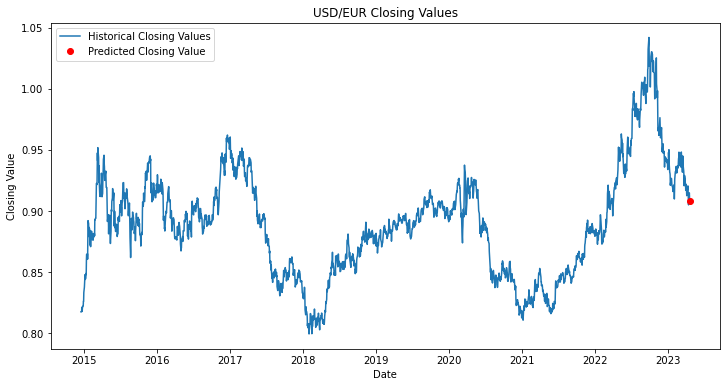

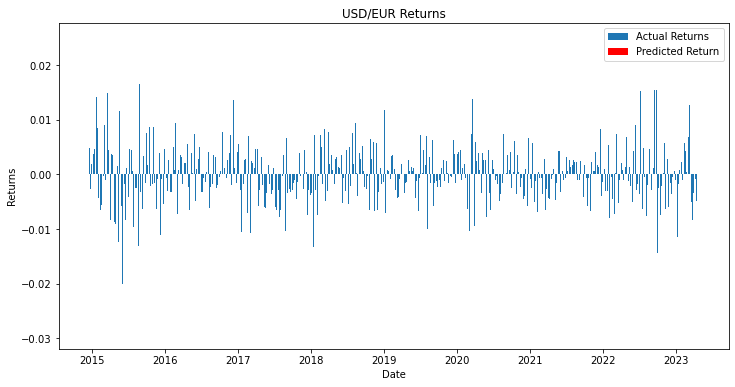

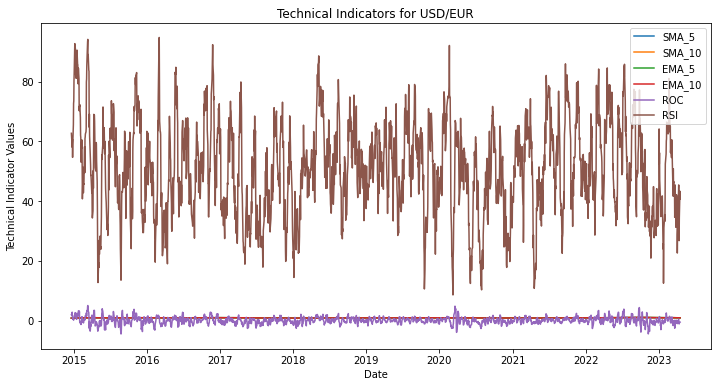

Processing currency pair: EUR/USD


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_5'] = moving_average(group['close'], 5)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_10'] = moving_average(group['close'], 10)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Random Forest Mean Squared Error for EUR/USD: 0.000026
Next day return for EUR/USD: 0.002022
Next day closing value for EUR/USD: 1.099268


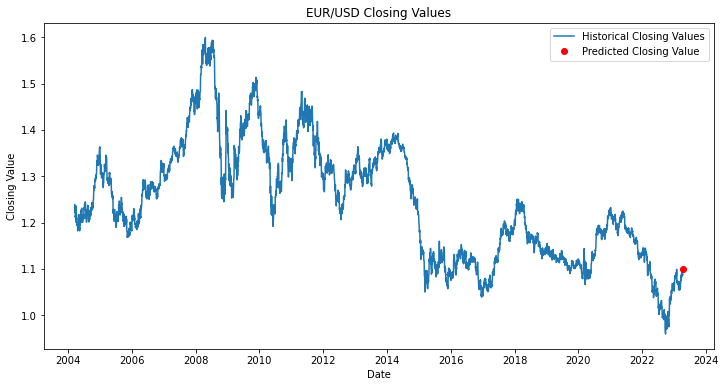

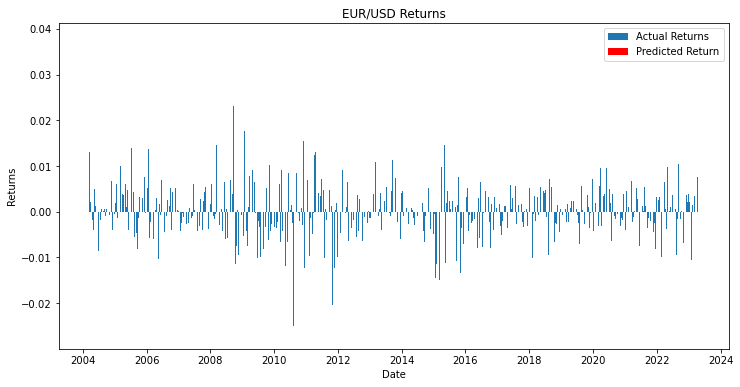

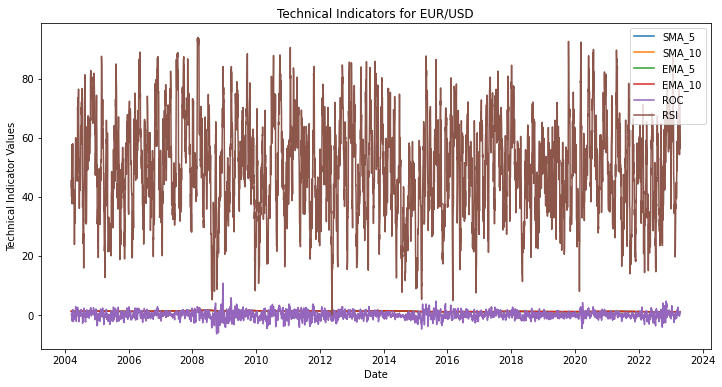

Processing currency pair: JPY/USD


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_5'] = moving_average(group['close'], 5)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_10'] = moving_average(group['close'], 10)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Random Forest Mean Squared Error for JPY/USD: 0.000081
Next day return for JPY/USD: 0.007019
Next day closing value for JPY/USD: 0.007512


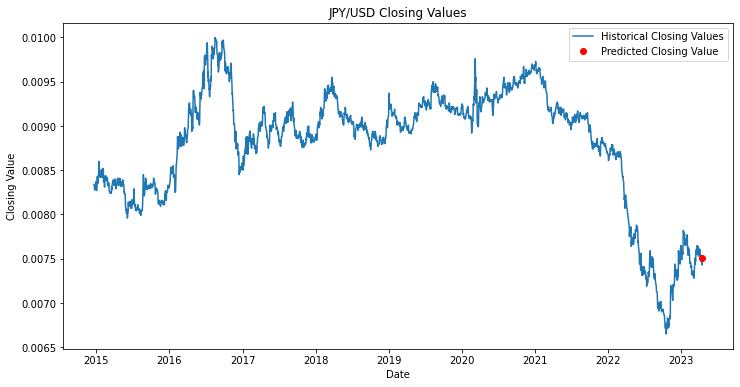

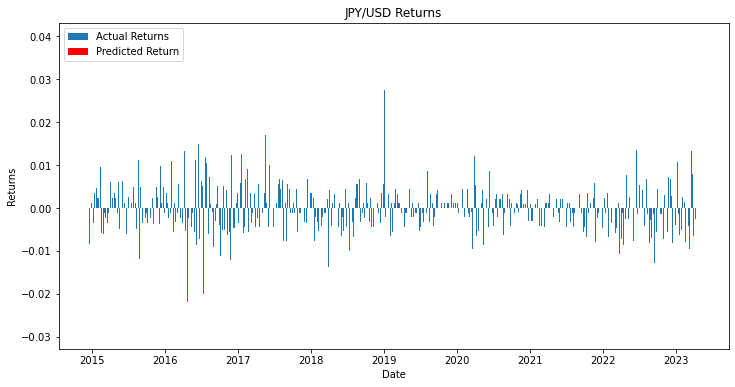

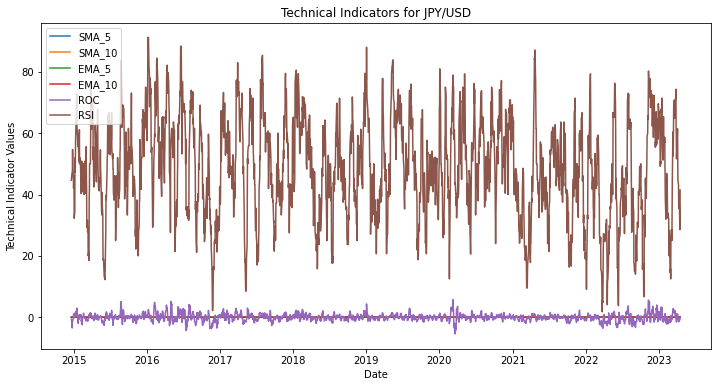

Processing currency pair: JPY/EUR


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_5'] = moving_average(group['close'], 5)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_10'] = moving_average(group['close'], 10)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Random Forest Mean Squared Error for JPY/EUR: 0.000049
Next day return for JPY/EUR: 0.006111
Next day closing value for JPY/EUR: 0.006842


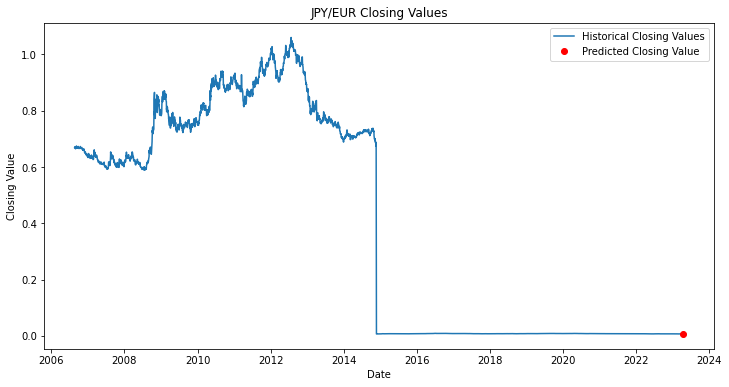

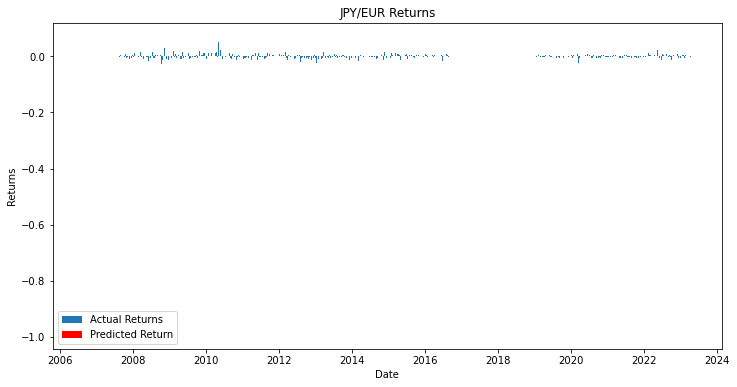

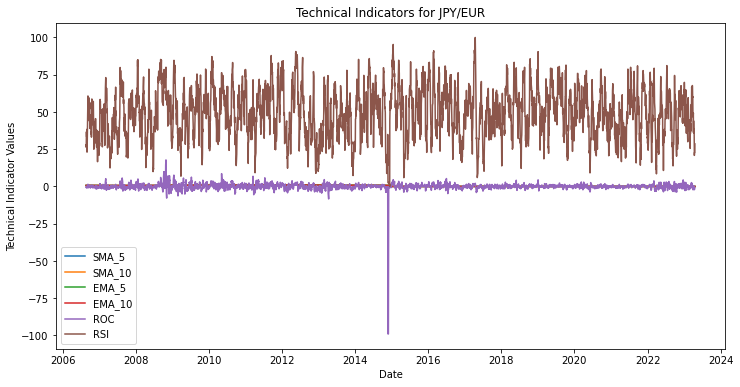

Processing currency pair: GBP/USD


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_5'] = moving_average(group['close'], 5)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_10'] = moving_average(group['close'], 10)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Random Forest Mean Squared Error for GBP/USD: 0.000131
Next day return for GBP/USD: 0.001940
Next day closing value for GBP/USD: 1.244861


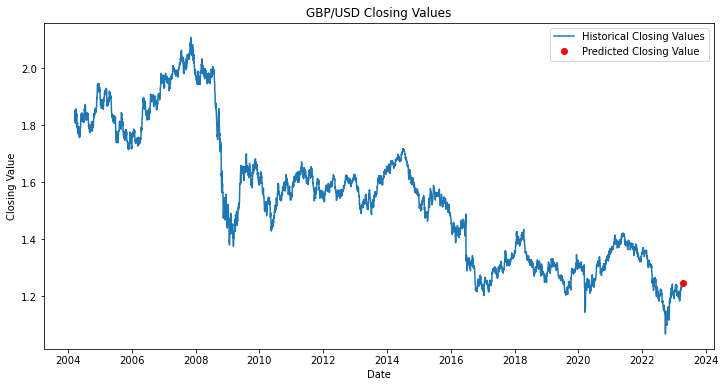

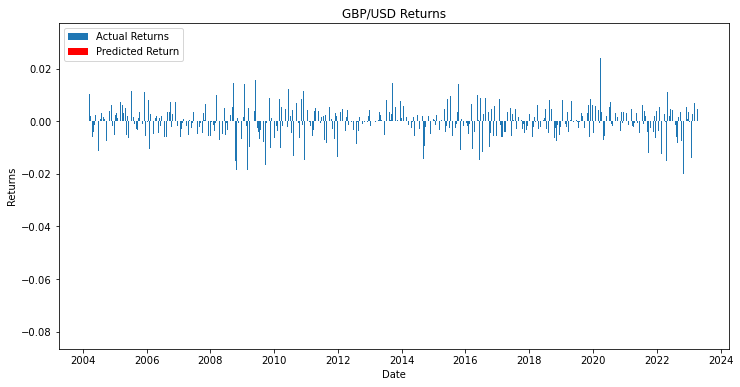

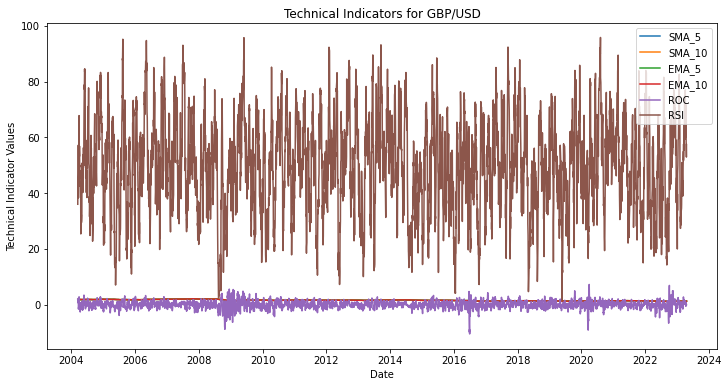

Processing currency pair: GBP/EUR
Not enough data for GBP/EUR
Processing currency pair: AUD/USD
Not enough data for AUD/USD
Processing currency pair: AUD/EUR
Not enough data for AUD/EUR
Processing currency pair: CAD/USD
Not enough data for CAD/USD
Processing currency pair: CAD/EUR
Not enough data for CAD/EUR
Processing currency pair: CHF/USD
Not enough data for CHF/USD
Processing currency pair: CHF/EUR
Not enough data for CHF/EUR
Processing currency pair: CNH/USD
Not enough data for CNH/USD
Processing currency pair: CNH/EUR
Not enough data for CNH/EUR


/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_5'] = moving_average(group['close'], 5)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['SMA_10'] = moving_average(group['close'], 10)
/var/folders/nv/rt4l_skx60z0323cx4jw9_yc0000gn/T/ipykernel_37837/2212863138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [52]:
currency_pairs = df[['from_currency', 'to_currency']].drop_duplicates().values

for pair in currency_pairs:
    from_currency, to_currency = pair
    print(f"Processing currency pair: {from_currency}/{to_currency}")
    
    pair_df = df[(df['from_currency'] == from_currency) & (df['to_currency'] == to_currency)]
    pair_df = create_features(pair_df)
    pair_df = pair_df.dropna()
    
    if pair_df.empty:
        print(f"Not enough data for {from_currency}/{to_currency}")
        print("=" * 40)
        continue
    
    X = pair_df[['SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 'ROC', 'RSI', 'returns', 'SMA_20', 'BB_upper', 'BB_lower']]
    y = pair_df['target']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    train_size = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Random Forest Mean Squared Error for {from_currency}/{to_currency}: {mse:.6f}")
    
    last_row = X_scaled[-1].reshape(1, -1)
    next_day_return = model.predict(last_row)
    print(f"Next day return for {from_currency}/{to_currency}: {next_day_return[0]:.6f}")
    
    last_close_value = pair_df.iloc[-1]['close']
    next_day_close_value = last_close_value * (1 + next_day_return[0])
    print(f"Next day closing value for {from_currency}/{to_currency}: {next_day_close_value:.6f}")

    pair_df['timestamp'] = pd.to_datetime(pair_df['timestamp'])
    
    # Plot closing values
    plt.figure(figsize=(12, 6))
    plt.plot(pair_df['timestamp'], pair_df['close'], label='Historical Closing Values')
    plt.plot(pair_df['timestamp'].iloc[-1] + pd.DateOffset(1), next_day_close_value, 'ro', label='Predicted Closing Value')
    plt.xlabel('Date')
    plt.ylabel('Closing Value')
    plt.title(f'{from_currency}/{to_currency} Closing Values')
    plt.legend()
    plt.show()

    # Plot returns
    plt.figure(figsize=(12, 6))
    plt.bar(pair_df['timestamp'], pair_df['returns'], label='Actual Returns')
    plt.bar(pair_df['timestamp'].iloc[-1] + pd.DateOffset(1), next_day_return, color='red', label='Predicted Return')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(f'{from_currency}/{to_currency} Returns')
    plt.legend()
    plt.show()

    # Plot technical indicators
    plt.figure(figsize=(12, 6))
    plt.plot(pair_df['timestamp'], pair_df['SMA_5'], label='SMA_5')
    plt.plot(pair_df['timestamp'], pair_df['SMA_10'], label='SMA_10')
    plt.plot(pair_df['timestamp'], pair_df['EMA_5'], label='EMA_5')
    plt.plot(pair_df['timestamp'], pair_df['EMA_10'], label='EMA_10')
    plt.plot(pair_df['timestamp'], pair_df['ROC'], label='ROC')
    plt.plot(pair_df['timestamp'], pair_df['RSI'], label='RSI')
    # Add other technical indicators as needed
    plt.xlabel('Date')
    plt.ylabel('Technical Indicator Values')
    plt.title(f'Technical Indicators for {from_currency}/{to_currency}')
    plt.legend()
    plt.show()
    
    
    print("=" * 40)

Random Forest Mean Squared Error: 0.000305


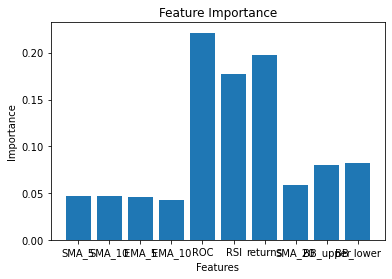

In [18]:
#Random Forest

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
print("Random Forest Mean Squared Error: {:.6f}".format(rf_mse))

importance = rf_model.feature_importances_
plt.bar(X.columns, importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

rf_predicted_close = X_test[:, 0] * (1 + rf_pred)

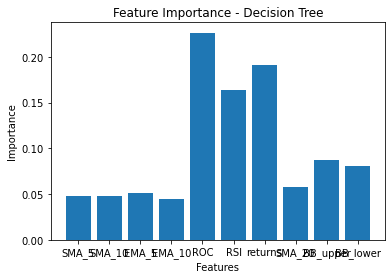

In [19]:
#Decision Tree Model
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_importance = dt_model.feature_importances_

plt.figure()
plt.bar(X.columns, dt_importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance - Decision Tree")
plt.show()

dt_predicted_close = X_test[:, 0] * (1 + dt_pred)

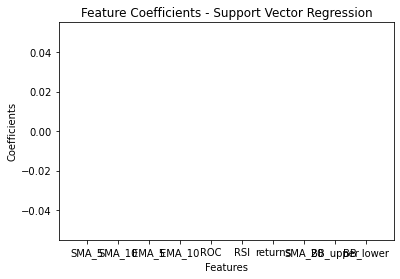

In [20]:
#SVM Model 
from sklearn.svm import SVR

svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_coef = svm_model.coef_[0]

plt.figure()
plt.bar(X.columns, svm_coef)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Feature Coefficients - Support Vector Regression")
plt.show()

svm_predicted_close = X_test[:, 0] * (1 + svm_pred)

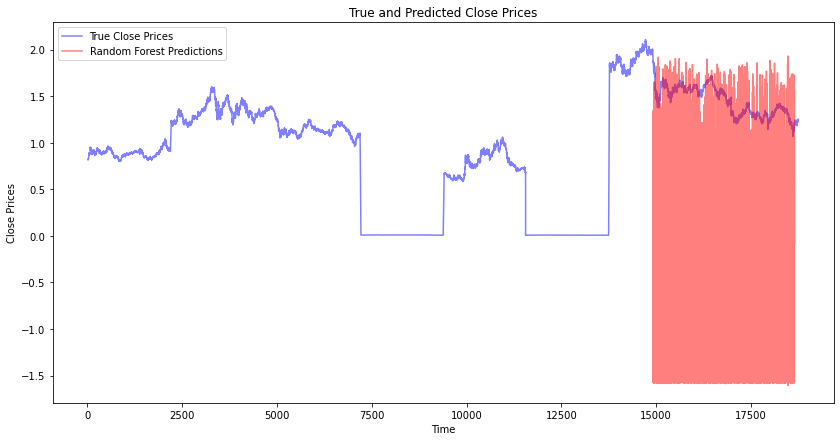

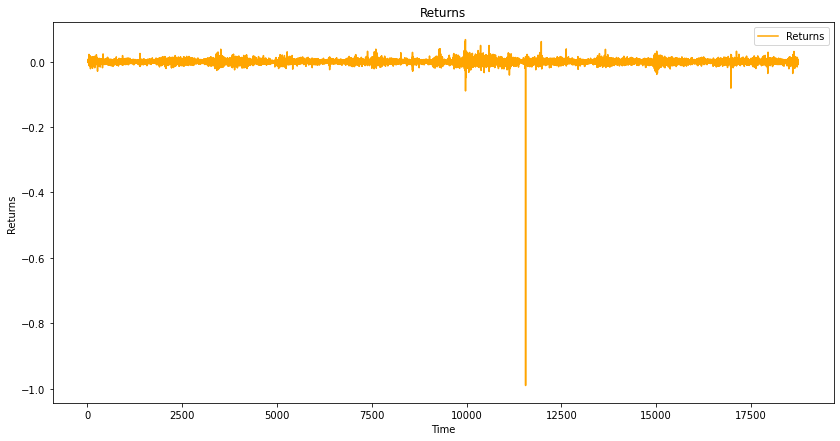

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(df["close"], label="True Close Prices", color="blue", alpha=0.5)

plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), rf_predicted_close, label="Random Forest Predictions", color="red", alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Close Prices")
plt.title("True and Predicted Close Prices")
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(df["returns"], label="Returns", color="orange")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Returns")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot closing values
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], label='Historical Closing Values')
plt.plot(df['date'].iloc[-1] + pd.DateOffset(1), predicted_closing_value, 'ro', label='Predicted Closing Value')
plt.xlabel('Date')
plt.ylabel('Closing Value')
plt.title('Currency Pair Closing Values')
plt.legend()
plt.show()

# Plot returns
plt.figure(figsize=(12, 6))
plt.bar(df['date'], df['returns'], label='Actual Returns')
plt.bar(df['date'].iloc[-1] + pd.DateOffset(1), predicted_return, color='red', label='Predicted Return')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Currency Pair Returns')
plt.legend()
plt.show()

# Plot technical indicators
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['SMA_5'], label='SMA_5')
plt.plot(df['date'], df['SMA_10'], label='SMA_10')
# Add other technical indicators as needed
plt.xlabel('Date')
plt.ylabel('Technical Indicator Values')
plt.title('Technical Indicators Over Time')
plt.legend()
plt.show()